# Under ice chlorophyll-a, oxygen and nitrate analysis

### Import packages

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import seawater as sw
from soccom_functions import *
import pickle 
import datetime
import xarray as xr
import pandas as pd 
import plotly.graph_objs as go
import cmocean
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline 
#!pip install PyAstronomy
from PyAstronomy import pyasl

### Read float data

For a single float

In [50]:
file_folder = "../../data/raw/WGfloats/" # specify directory relative to location of notebook #SOCCOM_HiResQC_LIAR_21Dec2021_netcdf
                # WGfloats
float_number = "5904397" #7900918 #9094/5904471 #5904397

files = sorted(glob.glob(file_folder+"/*"+float_number+"*.nc"))
print(files)
#files = sorted(glob.glob(file_folder+"/*.nc"))

['../../data/raw/WGfloats\\5904397_HRQC.nc']


### Loads and grids data from single float

In [51]:
#uses the function that reads and grids the data
FLOAT = grids_one_buoy(files[0],display_info = False, DO_ml_crit = 2.5, clear_short = True)

#the gridded data is located in the dictionary FLOAT.gr, and contains the following variables
print(FLOAT.gr.keys())
print(FLOAT.raw_bg.keys())
#some of them are standard and others related to thorpe scales and mixing, and you also have geopotential anomalies (gpa) integrated between 500 and 1500 m (gpa_500_1500)

print("This float is WMO code: %s"%(FLOAT.gr["WMO_code"]))

C:\Users\Clara Douglas\OneDrive - University of Southampton\PhD\Projects\net_community_production\notebooks\FromBieito\soccom_functions.py:338: RuntimeWarning: Mean of empty slice
  self.gr["LT"][j,i] = np.nanmean(disp[jj]**2)**0.5


dict_keys(['depth', 'date', 'date_dt', 'Lon', 'Lat', 'code', 'WMO_code', 'Pressure', 'Temperature', 'Salinity', 'SA', 'CT', 'Sigma_theta', 'gamma_n', 'N2', 'PV', 'Oxygen', 'OxygenSat', 'Nitrate', 'DIC_LIAR', 'TALK_LIAR', 'pCO2_LIAR', 'Chl_a', 'Chl_a_corr', 'POC', 'LT', 'mld', 'mld_HT', 'mld_DO', 'LT_ml', 'LT_ov', 'LT_largest_ov', 'size_largest_ov', 'h_largest_ov', 'h_no_ov', 'gpa', 'gpa_500_1500', 'AOU'])
dict_keys(['Oxygen', 'OxygenSat', 'Nitrate', 'DIC_LIAR', 'TALK_LIAR', 'pCO2_LIAR', 'Chl_a', 'Chl_a_corr', 'POC'])
This float is WMO code: 5904397


## Initial plot of the float main variables and position

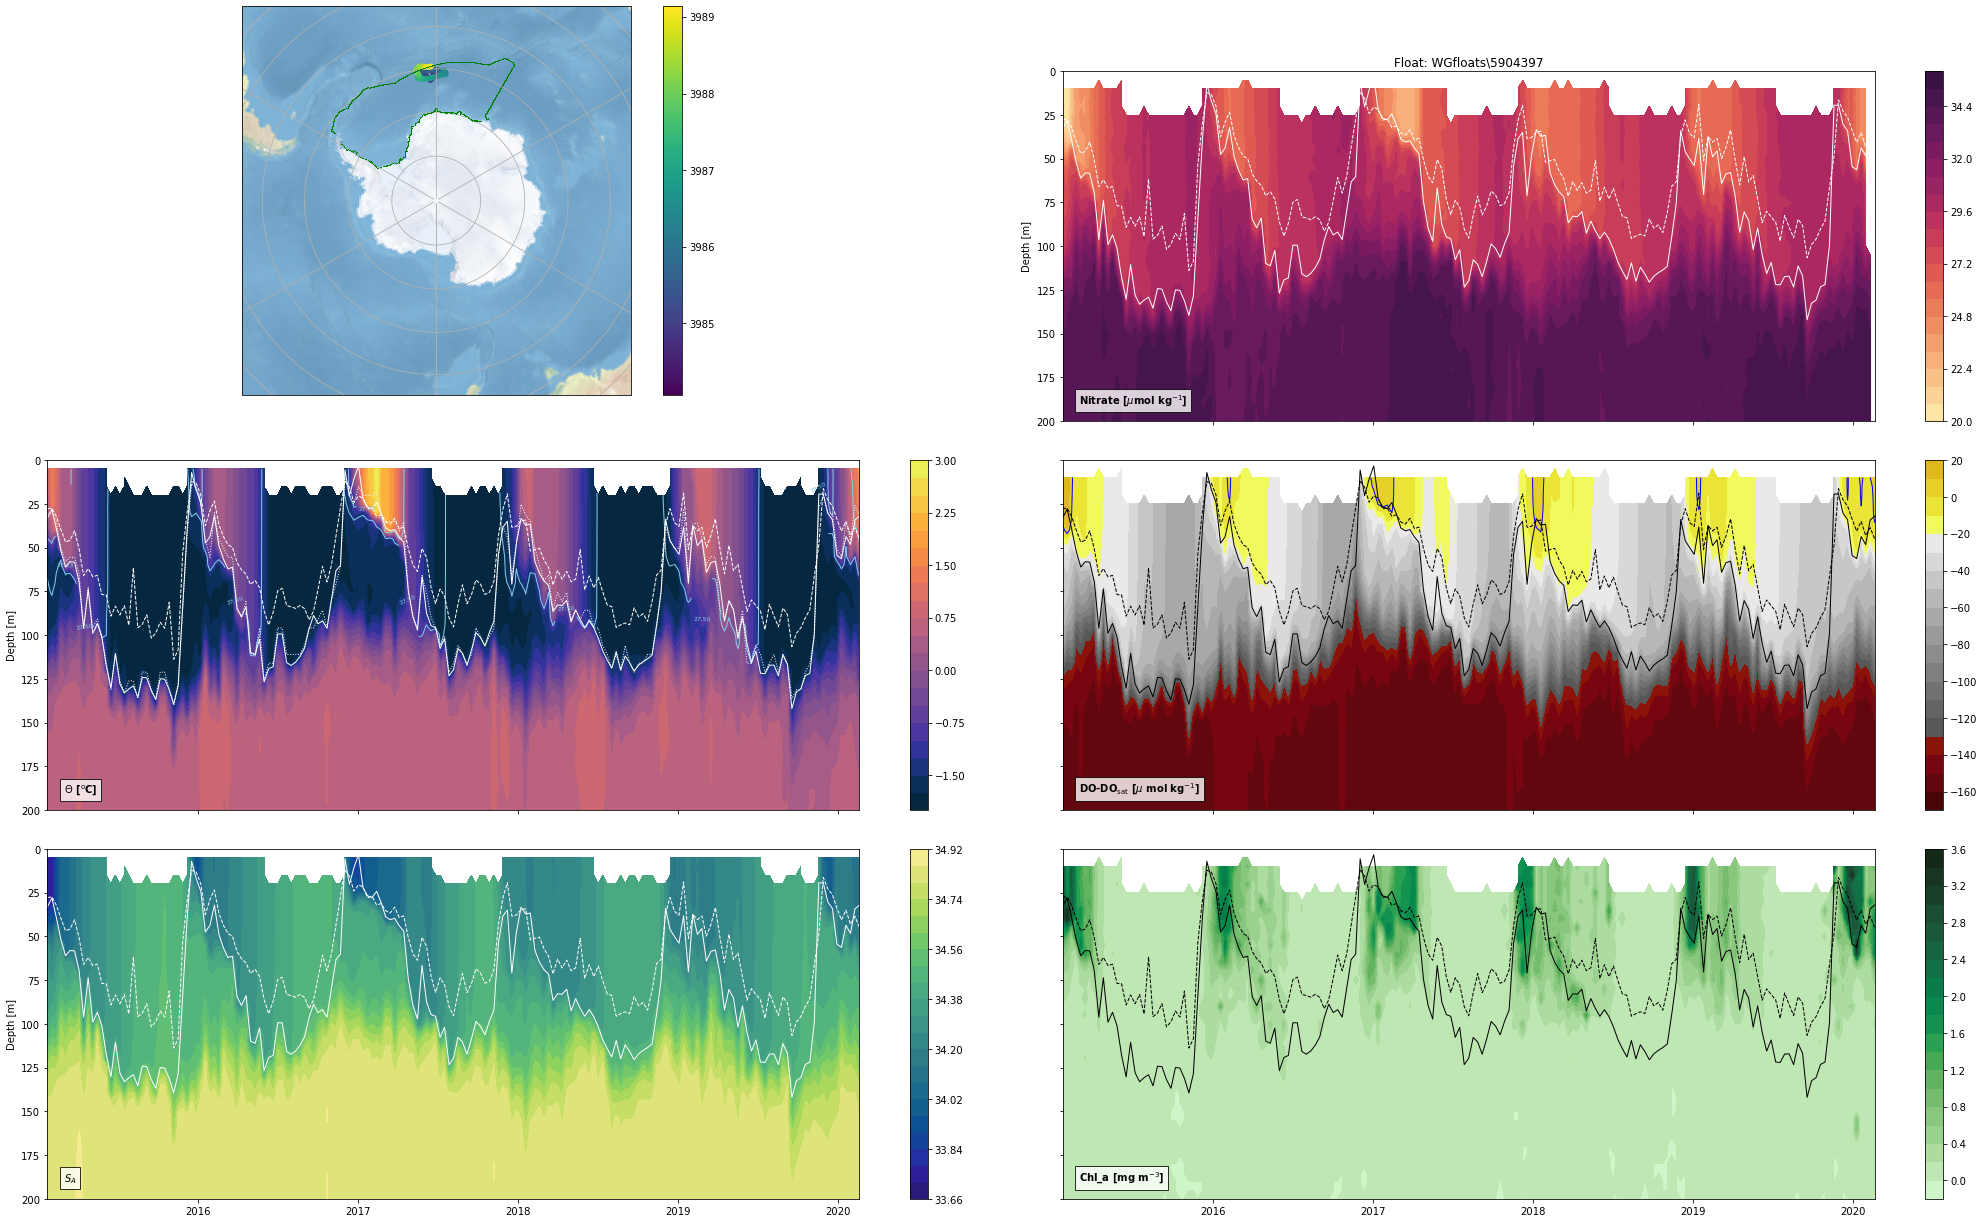

In [55]:
%matplotlib inline 
#qt
studyarea=pd.read_csv('../../data/processed/ANDREXbox.csv',header=None).values

#with this command you can have an overview of the float data 
FLOAT.plots_map_main_variables(studyarea, shows = True, saves = False,  ylim=  (200,0))
#FLOAT.plots_mixing_layer_profile(20, show = True)

#plt.plot(FLOAT.gr["date"],FLOAT.gr["gpa_500_1500"])

## Integrate chlorophyll 

Function for trapezoidal integration method:

In [5]:
# calculate the vertically integrated data column inventory using the composite trapezoidal rule
def integrate(zi, data, depth_range):
    n_profs = len(data)
    zi_start = abs(zi - depth_range[0]).argmin() # find location of start depth
    zi_end =  abs(zi - depth_range[1]).argmin() # find location of end depth
    zi_struct = np.ones((n_profs, 1)) * zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[:, zi_start : zi_end] # add +1 to get the 200m value
    col_inv = []
    for n in range(0, len(data)):
        col_inv.append(np.trapz(data[n,:][~np.isnan(data[n,:])], zi_struct[n,:][~np.isnan(data[n,:])]))
    return col_inv

### Using a fixed lower limit
Shallowest = 0m

Deepest = 200m (following previous studies of Nitrate drawdown, where 200m was the deepest MLD for all the floats in the region/SO)

In [65]:
# Interpolate/get data set up
zi = np.arange(0, 2005, 5) # 5 = 400 depth intervals between 0m to 2000m
    #or zi=self.gr["depth"] #which = np.arange(0,2000+dz,dz)
chl_int = FLOAT.gr["Chl_a"] # interpolated chl values across zi depth intervals for all profiles
print(chl_int.shape)
print(chl_int.T.shape)
print(len(chl_int.T))
      
# Integrate chl - total chl in upper 200m
upperlim=0
lowerlim=200

chl_intr200 = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 
#print(chl_intr200)
#len(chl_intr200)
print(chl_intr200.shape)

(401, 181)
(181, 401)
181
(181,)


Text(0.5, 0, 'Profile Number')

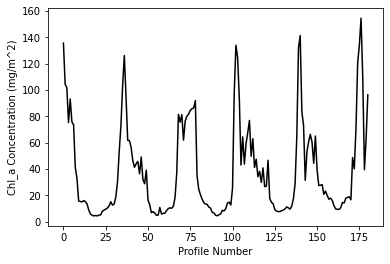

In [66]:
#Plot
plt.figure()
plt.plot(chl_intr200, c='black')
plt.ylabel('Chl_a Concentration (mg/m^2)')
plt.xlabel('Profile Number')

### Using the deepest MLD seen by the float

In [67]:
# Integrate chl - total chl in upper ML - to deepest MLD seen by float
upperlim=0
lowerlim=np.nanmax(FLOAT.gr["mld"])
print("Deepest mixed layer: %1.0f m"%(lowerlim))

chl_intr_dMLD = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 
#print(chl_intr_dMLD)
#len(chl_intr_dMLD)

Deepest mixed layer: 142 m


Text(0.5, 0, 'Profile Number')

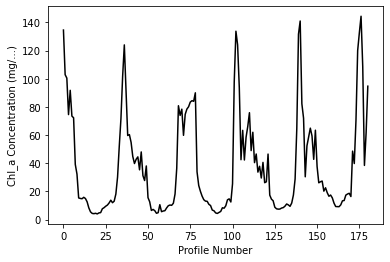

In [68]:
#Plot
plt.figure()
plt.plot(chl_intr_dMLD, c='black')
plt.ylabel('Chl_a Concentration (mg/...)')
plt.xlabel('Profile Number')

### Using the profile specific MLD

In [104]:
H2=FLOAT.gr["mld"]
nz= len(H2)
print(nz)
print(H2)

181
[ 33.24154917  27.99354834  39.43912387  51.9956211   61.08985682
  58.07437728  58.33796944  69.64916149  96.20599335  73.67669857
  99.05680659  93.39622414 101.15298819 117.78878131 130.33548016
 110.50732979 127.91133943 133.13640519 130.77959721 129.08669095
 135.42754559 124.21092067 124.48073928 131.81747176 136.86590388
 124.95707799 125.27037109 131.17469974 139.50880308 128.47585453
  83.82255694  39.776847     7.09304871  16.84661954  24.35621748
  47.4955193   43.84940657  32.15575314  48.79428165  56.66811949
  62.09979567  61.31913553  84.51327421  89.48319615  83.82654049
 109.85327178 111.14023345 102.39376673 126.81529006 119.23159163
 118.05202482  99.38642521  99.38583376 115.75702845 117.3834584
 115.49098225 112.18005666 107.41045728  96.45630102  88.79273834
  93.55369372  91.88851052  96.17953591  79.7037759   63.25290052
  60.18855242   5.61993374  20.34689848  10.78190321   3.36146149
  22.24512383  26.88267226  27.7624989   24.28686728  30.65390119
  38.77

In [105]:
# using MLD calculated for each individual profile
chl_T=chl_int.T # the interpolated chl from FLOAT.gr

# calculate the vertically integrated data column inventory using the composite trapezoidal rule
def integrate_wMLD(zi, data, start_depth, MLD):
    #n_profs = len(data)
    zi_start = abs(zi - start_depth).argmin() # find index of start depth
    zi_end =  abs(zi - MLD).argmin() # find index of end depth
    zi_struct = zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[zi_start : zi_end] # add +1 to get the 200m value
    col_inv = []
    #for n in range(0, len(data)):
    col_inv.append(np.trapz(data[:][~np.isnan(data[:])], zi_struct[:][~np.isnan(data[:])]))
    return col_inv

dint_chla = np.full( nz, np.nan )

print(chl_T.shape)
print(FLOAT.gr["depth"].shape)

for i in range(nz): #nz = length H2 (mld array) = number of profiles
    #print(i)
    if np.isnan(H2[i]):
        dint_chla[i] = np.nan # in float used to write code, there were some nan for MLD because of no salinity values recorded
    else:
        #jh = np.where( FLOAT.gr["depth"]>= H2[i])[0][0] # gets the depth index for the maxmum mixed layer
        #print(jh)
        lowerlim=H2[i]
        #print(lowerlim)
        data=chl_T[i,:]
        #print(len(data))
        #print(lowerlim)
        dint_chla[i] = np.array(integrate_wMLD(zi, data, upperlim, lowerlim)) # integrate interpolated nitrate values between 0m-specificMLD
    
#print(dint_chla)

(181, 401)
(401,)


Text(0.5, 0, 'Profile Number')

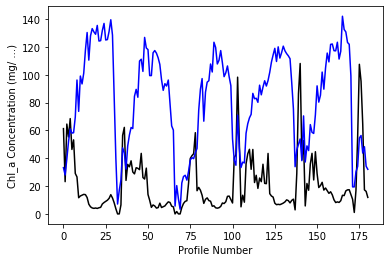

In [106]:
#Plot
plt.figure()
plt.plot(dint_chla, c='black')
plt.plot(H2, c='blue')
plt.ylabel('Chl_a Concentration (mg/ ...)')
plt.xlabel('Profile Number')
#plt.zlabel('MLD')

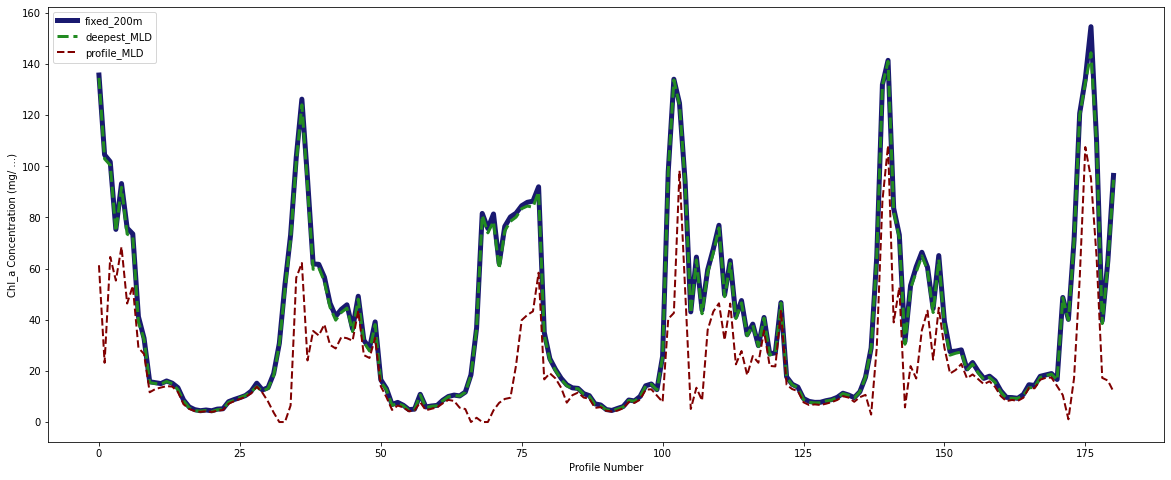

In [107]:
fig, ax = plt.subplots(figsize = (20, 8))
#chl_intr200, chl_intr_dMLD, dint_chla
fixed_200m,=plt.plot(chl_intr200, c='midnightblue',ls='-',lw=5)
deepest_MLD,=plt.plot(chl_intr_dMLD, c='forestgreen',ls='--',lw=3)
profile_MLD,=plt.plot(dint_chla, c='maroon',ls='--',lw=2)
ax.legend([fixed_200m, deepest_MLD,profile_MLD], ['fixed_200m', 'deepest_MLD', 'profile_MLD'])
#plt.gca().invert_yaxis()
plt.ylabel('Chl_a Concentration (mg/ ...)')
plt.xlabel('Profile Number')
#plt.title('Nitrate profile #1 from {0}'.format(timestamps[0]));
plt.show()

### The entire water column
Useful to see how different this is from integrating only in the ML - how much chl is being recorded below the mixed layer/below a fixed depth?

And should that be used to adjust the chl_a readings? - i.e. if floats are always recording chl at depth, does that need to shift/calibrate readings??

In [73]:
# Interpolate/get data set up
zi = np.arange(0, 2005, 5) # 5 = 400 depth intervals between 0m to 2000m
    #or zi=self.gr["depth"] #which = np.arange(0,2000+dz,dz)
chl_int = FLOAT.gr["Chl_a"] # interpolated chl values across zi depth intervals for all profiles
#print(chl_int.shape)
#print(chl_int.T.shape)

# Integrate chl - total chl in upper 200m
upperlim=0
lowerlim=2000

chl_intrWC = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 
#print(chl_intr200)
#len(chl_intr200)

Text(0.5, 0, 'Profile Number')

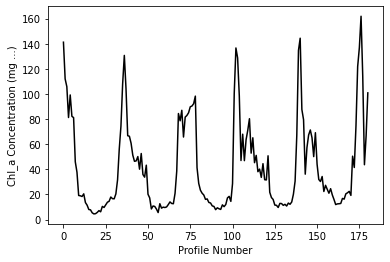

In [74]:
#Plot
plt.figure()
plt.plot(chl_intrWC, c='black')
plt.ylabel('Chl_a Concentration (mg ...)')
plt.xlabel('Profile Number')

## All together comparison

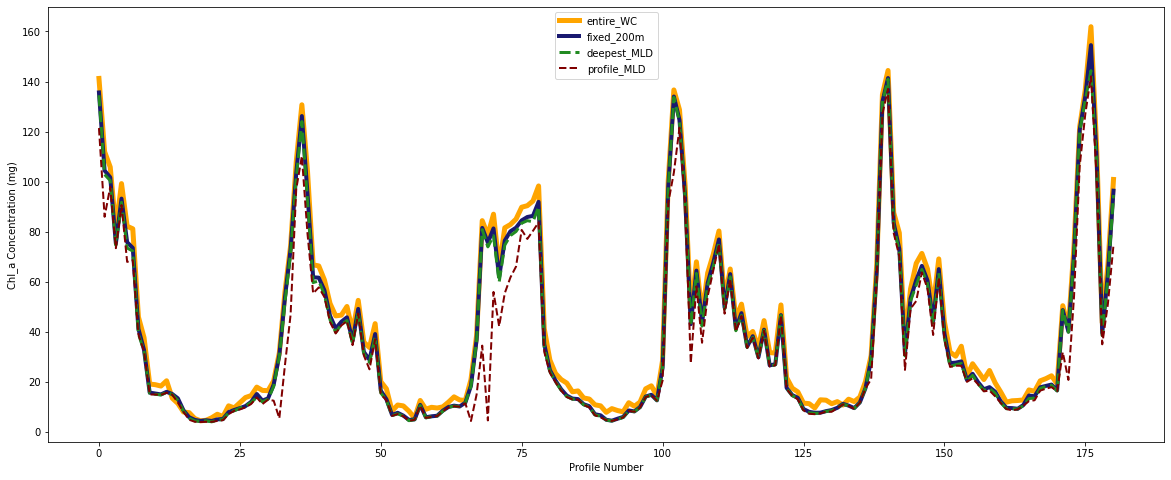

In [75]:
fig, ax = plt.subplots(figsize = (20, 8))
#chl_intr200, chl_intr_dMLD, dint_chla
entire_WC,=plt.plot(chl_intrWC, c='orange',ls='-',lw=5)
fixed_200m,=plt.plot(chl_intr200, c='midnightblue',ls='-',lw=4)
deepest_MLD,=plt.plot(chl_intr_dMLD, c='forestgreen',ls='--',lw=3)
profile_MLD,=plt.plot(dint_chla, c='maroon',ls='--',lw=2)
ax.legend([entire_WC,fixed_200m, deepest_MLD,profile_MLD], ['entire_WC','fixed_200m', 'deepest_MLD', 'profile_MLD'])
#plt.gca().invert_yaxis()
plt.ylabel('Chl_a Concentration (mg)')
plt.xlabel('Profile Number')
#plt.title('Nitrate profile #1 from {0}'.format(timestamps[0]));
plt.show()

##### As you can see, using profile MLD gives a lot lower values - and looking back at the time-depth plots, can see that there are chl hotspots below the MLD ... DCM??

#### Difference between mixed layer chl and water column chl

In [77]:
chl_200WC_diff=chl_intrWC-chl_intr200
#print(chl_200WC_diff)

## Identify which profiles were under ice

Having a look at float time/depth plots to see what depth float ascends to when under ice

Also: −1.78 ◦C is the float algorithm threshold that terminates float ascending to surface

(181,)
(401,)
(401, 181)
[ 0.  5. 10. 15.]


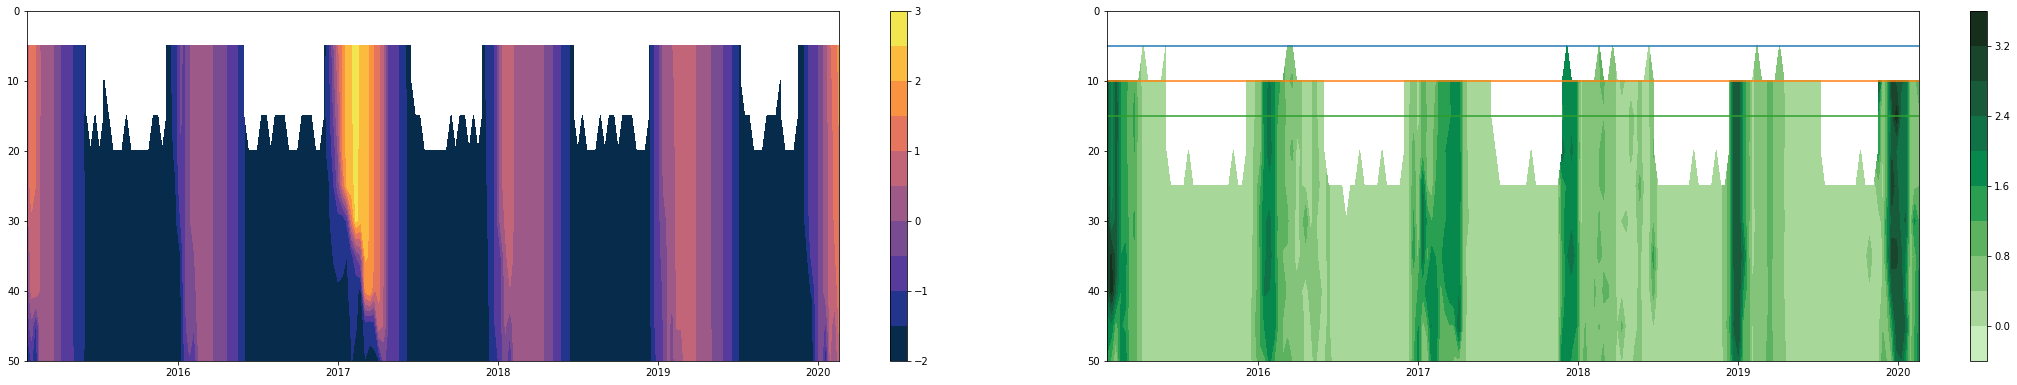

In [78]:
fig = plt.figure(figsize = (30,18))
ax0 = fig.add_axes([0.57,0.35,0.47,0.27])
#num=np.arange(1,234,1)
print(FLOAT.gr["date"].shape)
print(FLOAT.gr["depth"].shape)
print(FLOAT.gr["Chl_a"].shape)
cfT=ax0.contourf(FLOAT.gr["date_dt"],FLOAT.gr["depth"][0:320],FLOAT.gr["Chl_a"][0:320],10, cmap = cmocean.cm.algae)
ax0.set_ylim(0,50)
plt.gca().invert_yaxis()
cb = fig.colorbar(cfT)

ax0.plot(FLOAT.gr["date_dt"],np.full(FLOAT.gr["date"].size,5)) #i=1
ax0.plot(FLOAT.gr["date_dt"],np.full(FLOAT.gr["date"].size,10)) #i=2
ax0.plot(FLOAT.gr["date_dt"],np.full(FLOAT.gr["date"].size,15)) #i=3


ax1 = fig.add_axes([0.07,0.35,0.47,0.27])
cfTT=ax1.contourf(FLOAT.gr["date_dt"],FLOAT.gr["depth"][0:320],FLOAT.gr["Temperature"][0:320],10, cmap = cmocean.cm.thermal)
ax1.set_ylim(0,50)
plt.gca().invert_yaxis()
cb = fig.colorbar(cfTT)


print(FLOAT.gr["depth"][0:4])

In [99]:
yesno4=np.full(nz, np.nan)
yesnotemp=np.full(nz, np.nan)
for i in range(nz):
    test=np.isnan(FLOAT.gr["Chl_a"][0,i]) & np.isnan(FLOAT.gr["Chl_a"][1,i]) & np.isnan(FLOAT.gr["Chl_a"][2,i]) #& np.isnan(FLOAT.gr["Chl_a"][3,i]) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
    #temp_thres=np.nanmedian(FLOAT.gr["Temperature"][4:11,i])<(-1.78)
    #print(test)
    #print(temp_thres)
    if test:
        yesno4[i]=180
    else:
        yesno4[i]=0
    #if test&temp_thres:
    #    yesnotemp[i]=180
    #else:
    #    yesnotemp[i]=0
#print(FLOAT.gr["depth"][4:11])

#print(yesnotemp[-10])
#print(FLOAT.gr["date_dt"][-10])
#print(FLOAT.gr["Chl_a"][0:15,-10])

0.0
2019-11-18 04:13:59.999997
[       nan        nan 2.84472759 1.36820363 1.43454853 0.66520463
 0.23476905 0.30277329 0.26163231 0.26862288 0.30201503 0.2255105
 0.27846336 0.26327196 0.24041306]


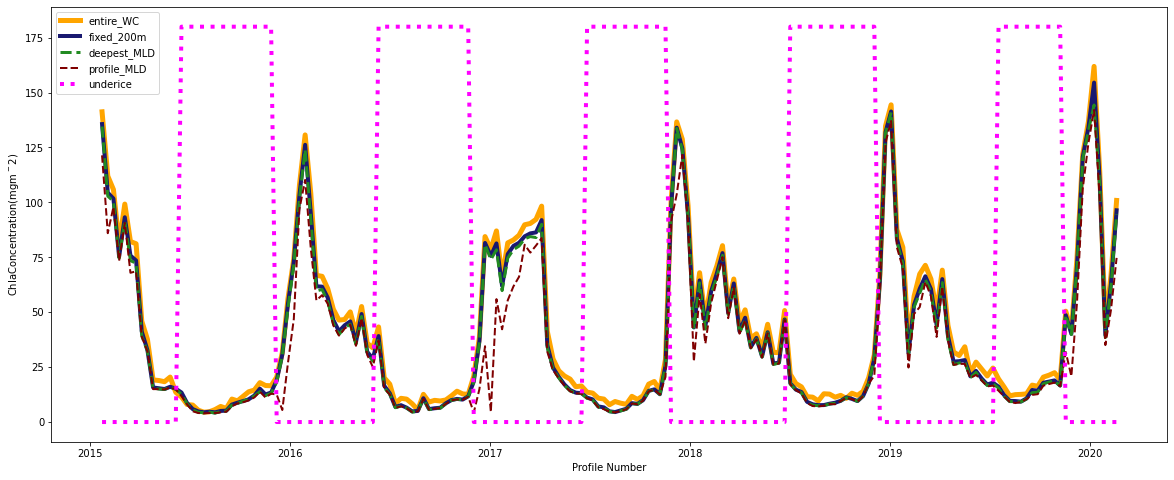

In [100]:
fig, ax = plt.subplots(figsize = (20, 8))
#chl_intr200, chl_intr_dMLD, dint_chla
entire_WC,=plt.plot(FLOAT.gr["date_dt"],chl_intrWC, c='orange',ls='-',lw=5)
fixed_200m,=plt.plot(FLOAT.gr["date_dt"],chl_intr200, c='midnightblue',ls='-',lw=4)
deepest_MLD,=plt.plot(FLOAT.gr["date_dt"],chl_intr_dMLD, c='forestgreen',ls='--',lw=3)
profile_MLD,=plt.plot(FLOAT.gr["date_dt"],dint_chla, c='maroon',ls='--',lw=2)
underice4,=plt.plot(FLOAT.gr["date_dt"],yesno4,c='lightblue',ls=':',lw=4)
underice4,=plt.plot(FLOAT.gr["date_dt"],yesnotemp,c='magenta',ls=':',lw=4)
ax.legend([entire_WC,fixed_200m, deepest_MLD,profile_MLD,underice4], ['entire_WC','fixed_200m', 'deepest_MLD', 'profile_MLD','underice'])
#plt.gca().invert_yaxis()
plt.ylabel(r'$\mathregular {Chl a Concentration (mg {m^-2})}$')
plt.xlabel('Profile Number')
#plt.title('Nitrate profile #1 from {0}'.format(timestamps[0]));
plt.show()

## How much of the annual chl was present under ice?
* Integrate profile chl total to get austral total
* Integrate chl for under ice profiles only
* Calculate proportion/% of under-ice chl per year

#### Over the whole float timeseries

In [21]:
ui=np.where(np.isnan(FLOAT.gr["Chl_a"][0,:]) & np.isnan(FLOAT.gr["Chl_a"][1,:]) & np.isnan(FLOAT.gr["Chl_a"][2,:]) & np.isnan(FLOAT.gr["Chl_a"][3,:])) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
print(ui)
print(FLOAT.gr["Chl_a"].shape)
print(chl_intr_dMLD.shape)
ui_tot=np.nansum(chl_intr_dMLD[ui])


test=np.where(np.invert(np.isnan(FLOAT.gr["Chl_a"][0,:]) & np.isnan(FLOAT.gr["Chl_a"][1,:]) & np.isnan(FLOAT.gr["Chl_a"][2,:]) & np.isnan(FLOAT.gr["Chl_a"][3,:]))) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
print(test)


nui=np.where(np.isfinite(FLOAT.gr["Chl_a"][0,:]) & np.isnan(FLOAT.gr["Chl_a"][1,:]) & np.isnan(FLOAT.gr["Chl_a"][2,:]) & np.isnan(FLOAT.gr["Chl_a"][3,:])) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
#print(nui)
#print(FLOAT.gr["Chl_a"].shape)
#print(chl_intr_dMLD.shape)
nui_tot=np.nansum(chl_intr_dMLD[test])

print(np.nansum(chl_intr_dMLD))

print('approx % of chl under ice during float timeseries:', round(ui_tot/nui_tot*100,2),'%')

(array([  8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  22,  23,  24,  26,  27,  29,  30,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  64,  65,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138], dtype=int64),)
(401, 151)
(151,)
(array([  0,   1,   2,   3,   4,   5,   6,   7,  25,  28,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  62,  63,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  90,
        91, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150], dtype=int64),)
5617.680984575476
approx % of chl under ice during float timeseries: 11.4 %


##### Get year range

In [22]:
startyear=FLOAT.gr["date_dt"][0].year
endyear=FLOAT.gr["date_dt"][-1].year
print(startyear, '-', endyear)

#make structure for floats and the years
AllFloats = {}
AllFloats[FLOAT.gr["WMO_code"]] = {}
for yix in range(startyear,endyear+1,1):
    AllFloats[FLOAT.gr["WMO_code"]][yix] ={}
    #print(yix-0.5)
print(AllFloats[FLOAT.gr["WMO_code"]])
print(AllFloats)

2015 - 2019
{2015: {}, 2016: {}, 2017: {}, 2018: {}, 2019: {}}
{'5904472': {2015: {}, 2016: {}, 2017: {}, 2018: {}, 2019: {}}}


#### get index for profiles that are in austral year, under ice and ice free

In [23]:
for yix in range(startyear,endyear+1,1):
    AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=[]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=[]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=[]
    for i in range(len(FLOAT.gr["date_dt"])):
        decy = pyasl.decimalYear(FLOAT.gr["date_dt"][i]) #might be more efficient to make decy an np.int_ here so all the logical queries can be called at once?...
        smol=decy>=(yix-0.5)
        tol=decy<(yix+0.5)
        underice=yesno4[i]>0
        icefree=yesno4[i]==0
        if smol==tol:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"],np.int_(i))
        if smol==tol==underice:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"],i)
        if smol==tol==icefree:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"],i)
    AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"])
    AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"])
    AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"])
display(AllFloats['5904472'][endyear])
len(AllFloats['5904472'][endyear]["aust_ix"]) # probably exlude years with <34 profiles from next lot of calculations

{'aust_ix': array([123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
        136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
        149, 150]),
 'underice_ix': array([123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
        136, 137, 138]),
 'icefree_ix': array([139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150])}

28

### Calculate how much Chl is present at specific times - whole year, under ice, when there's no ice

In [24]:
for yix in range(startyear,endyear+1,1):
    #could add if rule: if len(AllFloats['5904472'][endyear]["aust_ix"])<34: continue... or [] =np.nan
    
    #### Total in austral year
    AllFloats['5904472'][yix]["Tot_aus_chl"]=np.round(np.nansum(chl_intrWC[AllFloats['5904472'][yix]["aust_ix"]]),6)
    #print(AllFloats['5904472'][yix]["Tot_aus_chl"])
    
    #### Total under ice
    AllFloats['5904472'][yix]["Tot_underice_chl"]=np.round(np.nansum(chl_intrWC[AllFloats['5904472'][yix]["underice_ix"]]),6)
    #print(AllFloats['5904472'][yix]["Tot_underice_chl"])
    
    #### Total when ice-free
    #totIF2016=np.round(np.nansum(chl_intrWC[if2016]),6)
    #print(totIF2016)
    AllFloats['5904472'][yix]["Tot_icefree_chl"]=np.round(np.nansum(chl_intrWC[AllFloats['5904472'][yix]["icefree_ix"]]),6)
    #print(AllFloats['5904472'][yix]["Tot_icefree_chl"])
    
    #### proportion under ice for austral year
    AllFloats['5904472'][yix]["Prop_underice"]=AllFloats['5904472'][yix]["Tot_underice_chl"]/AllFloats['5904472'][yix]["Tot_aus_chl"]
    AllFloats['5904472'][yix]["Prop_icefree"]=AllFloats['5904472'][yix]["Tot_icefree_chl"]/AllFloats['5904472'][yix]["Tot_aus_chl"]
    
    #### Mean [Chl] in WC
    #AllFloats['5904472'][yix]["Mean_aus_chl"]=np.round(np.nanmean(chl_intrWC[AllFloats['5904472'][yix]["aust_ix"]]),6)
    
for yix in range(startyear,endyear+1,1):
    print(yix,"under ice",np.round(AllFloats['5904472'][yix]["Prop_underice"],3))
for yix in range(startyear,endyear+1,1):
    print(yix,"ice free",np.round(AllFloats['5904472'][yix]["Prop_icefree"],3))

2015 under ice 0.216
2016 under ice 0.232
2017 under ice 0.082
2018 under ice 0.189
2019 under ice 0.219
2015 ice free 0.784
2016 ice free 0.768
2017 ice free 0.918
2018 ice free 0.811
2019 ice free 0.781


## What is happening to the chl when the satellite isn't seeing the ice-free waters (from ~mid March)?
lines across region from:
* 2015 - 30th March
* 2016 -  21st March
* 2017 - 22nd March
* 2018 - 14th March/22nd March
* 2019 - 14th March/22nd March
* 2020 - 21st March
* 2021 - No satellite data yet

In [25]:
Mar3015=datetime.datetime(2015,3,30)
decmar15=pyasl.decimalYear(Mar3015)
Mar2116=datetime.datetime(2016,3,21)
decmar16=pyasl.decimalYear(Mar2116)
Mar2217=datetime.datetime(2017,3,22)
decmar17=pyasl.decimalYear(Mar2217)
Mar1418=datetime.datetime(2018,3,14)
decmar18=pyasl.decimalYear(Mar1418)
Mar1419=datetime.datetime(2019,3,14)
decmar19=pyasl.decimalYear(Mar1419)
Mar2120=datetime.datetime(2020,3,21)
decmar20=pyasl.decimalYear(Mar2120)

In [26]:
for yix in range(startyear,endyear+1,1):
    AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=[]

    for i in range(len(FLOAT.gr["date_dt"])):
        decy = pyasl.decimalYear(FLOAT.gr["date_dt"][i])
        smol=decy>=(yix-0.5)
        tol=decy<(yix+0.5)
        icefree=yesno4[i]==0
        if yix==2015:
            mar=decy>decmar15
        elif yix==2016:
            mar=decy>decmar16
        elif yix==2017:
            mar=decy>decmar17
        elif yix==2018:
            mar=decy>decmar18
        elif yix==2019:
            mar=decy>decmar19
        elif yix==2020:
            mar=decy>decmar20

        if smol==tol==icefree==mar:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"],i)
    AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"])
display(AllFloats['5904472'][2018]) #

{'aust_ix': array([ 87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122]),
 'underice_ix': array([ 87,  88,  89,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 115, 116, 117, 118, 119, 120, 121, 122]),
 'icefree_ix': array([ 90,  91, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]),
 'Tot_aus_chl': 1527.948381,
 'Tot_underice_chl': 289.351852,
 'Tot_icefree_chl': 1238.596528,
 'Prop_underice': 0.18937279269253013,
 'Prop_icefree': 0.8106272066529976,
 'no_sat': array([112, 113, 114])}

In [27]:
for yix in range(startyear,endyear+1,1):
    #could add if rule: if len(AllFloats['5904472'][endyear]["aust_ix"])<34: continue... or [] =np.nan
    
    #### Total chl when satellite field of view reduces during March, but before ice returns
    AllFloats['5904472'][yix]["Tot_nosat_chl"]=np.round(np.nansum(chl_intrWC[AllFloats['5904472'][yix]["no_sat"]]),6)
    #print(AllFloats['5904472'][yix]["Tot_nolight_chl"])
    
    #### proportion under ice for austral year
    AllFloats['5904472'][yix]["Prop_nosat"]=AllFloats['5904472'][yix]["Tot_nosat_chl"]/AllFloats['5904472'][yix]["Tot_aus_chl"]
    #print(AllFloats['5904472'][yix]["Prop_nolight"])

for yix in range(startyear,endyear+1,1):
    print(yix,"no satellite coverage",np.round(AllFloats['5904472'][yix]["Prop_nosat"],3))

2015 no satellite coverage 0.073
2016 no satellite coverage 0.054
2017 no satellite coverage 0.023
2018 no satellite coverage 0.161
2019 no satellite coverage 0.252


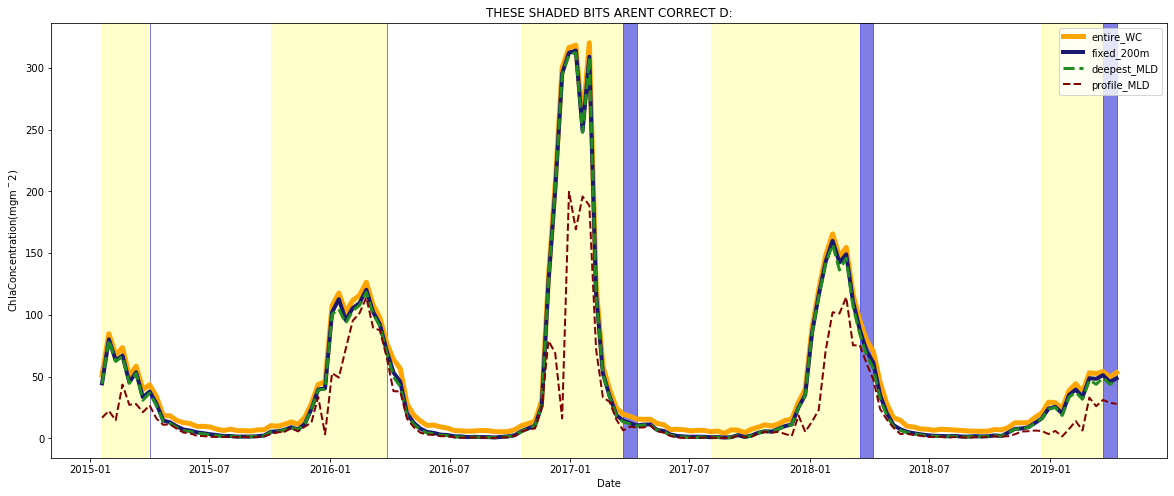

In [28]:
fig, ax = plt.subplots(figsize = (20, 8))
#chl_intr200, chl_intr_dMLD, dint_chla
entire_WC,=plt.plot(FLOAT.gr["date_dt"],chl_intrWC, c='orange',ls='-',lw=5)
fixed_200m,=plt.plot(FLOAT.gr["date_dt"],chl_intr200, c='midnightblue',ls='-',lw=4)
deepest_MLD,=plt.plot(FLOAT.gr["date_dt"],chl_intr_dMLD, c='forestgreen',ls='--',lw=3)
profile_MLD,=plt.plot(FLOAT.gr["date_dt"],dint_chla, c='maroon',ls='--',lw=2)

for yix in range(startyear,endyear+1,1):
    #plt.axvspan(FLOAT.gr["date_dt"][AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"][0]], FLOAT.gr["date_dt"][AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"][-1]], color='grey', alpha=0.2)
    plt.axvspan(FLOAT.gr["date_dt"][AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"][0]], FLOAT.gr["date_dt"][AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"][-1]], color='yellow', alpha=0.2)
    plt.axvspan(FLOAT.gr["date_dt"][AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"][0]], FLOAT.gr["date_dt"][AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"][-1]], color='blue', alpha=0.5)


ax.legend([entire_WC,fixed_200m, deepest_MLD,profile_MLD], ['entire_WC','fixed_200m', 'deepest_MLD', 'profile_MLD'])
#plt.gca().invert_yaxis()
plt.ylabel(r'$\mathregular {Chl a Concentration (mg {m^-2})}$')
plt.xlabel('Date')
plt.title('THESE SHADED BITS ARENT CORRECT D:');
plt.show()

## Export integrated chl timeseries for plotting alongside local NPP data in matlab (or import values from matlab to here)

Could also look at nitrate drawdown, oxygen production, backscatter... 

In [29]:
#

### Mean [Chl] in upper 200m... and Max [Chl] and where max occurs

In [30]:
D = 200 
jh = np.where( FLOAT.gr["depth"]>= D)[0][0] # gets the depth index for the maxmum mixed layer ([0][0] requests the first instance - so the shallowest depth point that is greater or equal to MLD)
mean200_Chl_a = np.nanmean(FLOAT.gr["Chl_a"][:jh,:], axis = 0)

max_Chl_a= np.nanmax(FLOAT.gr["Chl_a"][:,:], axis = 0)
#print(max_Chl_a[0])
max_Chl_depth = np.full( nz, np.nan )
max_Chl_ix = np.full( nz, np.nan )

for i in range(nz):
    max_Chl_ix[i] = np.where( FLOAT.gr["Chl_a"][:,i]>= max_Chl_a[i])[0][0]
    max_Chl_ix=np.int_(max_Chl_ix)
#print(max_Chl_ix)
max_Chl_depth=FLOAT.gr["depth"][max_Chl_ix]
print(max_Chl_depth)

[ 40.  35.  45.  25.  40.  50.  30.  55.  25.  45.  25.  40.  45.  75.
  25.  55.  60.  25.  65.  25.  25.  40.  50.  35.  50.  55.  40.  25.
   5.  25.  65.  65.  10.  35.  30.  35.  30.  45.  30.  25.  25.  10.
  40.  35.  65.  55.  30.  60.  25.  55.  40.  50.  45. 160.  25.  30.
  50.  50.  55.  25.  25.  20.  25.  15.  30.  40.  25.  35.  50.  10.
  20.  15.  30.  45.  45.  40.  60.  20.  60.  35.  55.  25.  50.  70.
  50. 105.  25.  55.  70.  65.  80.  60.  30.  35.  40.  25.  70.  30.
  30.  25.  25.  25.  20.  60.  40.  40.  45.  45.  35.  35.  25.  35.
  40.  40.  60.  65.  30.  35.  80.  65.  30.  35.  25.  55.  25.  90.
  90.  80.  25. 100.  25.  20.  25.  30.  35.  55.  45.  25.  40.  15.
  55.  75.  85.  40.  45.  75.  30.  55.  55.  60.  80.]


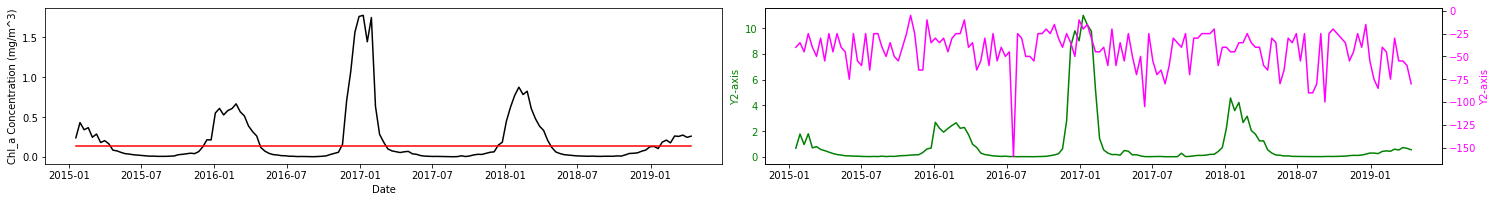

In [32]:
#Plot
fig = plt.figure(figsize = (20,8))
ax0 = fig.add_axes([0.07,0.35,0.47,0.27])

ax0.plot(FLOAT.gr["date_dt"],mean200_Chl_a, c='black')
ax0.plot(FLOAT.gr["date_dt"], np.full(nz,0.14), "r")
underice4,=ax1.plot(FLOAT.gr["date_dt"],yesno4/100,c='lightblue',ls=':',lw=2)
plt.ylabel('Chl_a Concentration (mg/m^3)')
plt.xlabel('Date')

ax1 = fig.add_axes([0.57,0.35,0.47,0.27])
color='green'
ax1.set_ylabel('Y2-axis', color = color)
ax1.plot(FLOAT.gr["date_dt"],max_Chl_a, c='green')
ax1.tick_params(axis ='y', labelcolor = color)
#plt.plot(chl_intrWC, c='black')


ax3=ax1.twinx()
#ax3.spines.right.set_position(("axes", 1.05))
color='magenta'
ax3.set_ylabel('Y2-axis', color = color)
ax3.plot(FLOAT.gr["date_dt"],(max_Chl_depth*-1), c='magenta')
ax3.tick_params(axis ='y', labelcolor = color)


#for yix in range(startyear,endyear+1,1):
#    #plt.axvspan(FLOAT.gr["date_dt"][AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"][0]], FLOAT.gr["date_dt"][AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"][-1]], color='grey', alpha=0.2)
#    plt.axvspan(FLOAT.gr["date_dt"][AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"][0]], FLOAT.gr["date_dt"][AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"][-1]], color='yellow', alpha=0.2)
#    plt.axvspan(FLOAT.gr["date_dt"][AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"][0]], FLOAT.gr["date_dt"][AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"][-1]], color='blue', alpha=0.5)


# All floats
## Define functions for loop

In [2]:
# calculate the vertically integrated data column inventory using the composite trapezoidal rule
def integrate(zi, data, depth_range):
    n_profs = len(data)
    zi_start = abs(zi - depth_range[0]).argmin() # find location of start depth
    zi_end =  abs(zi - depth_range[1]).argmin() # find location of end depth
    zi_struct = np.ones((n_profs, 1)) * zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[:, zi_start : zi_end] # add +1 to get the 200m value
    col_inv = []
    for n in range(0, len(data)):
        col_inv.append(np.trapz(data[n,:][~np.isnan(data[n,:])], zi_struct[n,:][~np.isnan(data[n,:])]))
    return col_inv

In [3]:
# calculate the vertically integrated data column inventory using the composite trapezoidal rule
def integrate_wMLD(zi, data, start_depth, MLD):
    #n_profs = len(data)
    zi_start = abs(zi - start_depth).argmin() # find index of start depth
    zi_end =  abs(zi - MLD).argmin() # find index of end depth
    zi_struct = zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[zi_start : zi_end] # add +1 to get the 200m value
    col_inv = []
    #for n in range(0, len(data)):
    col_inv.append(np.trapz(data[:][~np.isnan(data[:])], zi_struct[:][~np.isnan(data[:])]))
    return col_inv

In [53]:
def integrate_chl(data):
    # Interpolate/get data set up
    zi = np.arange(0, 2005, 5) # 5 = 400 depth intervals between 0m to 2000m
    #or zi=self.gr["depth"] #which = np.arange(0,2000+dz,dz)
    chl_int = FLOAT.gr["Chl_a"] # interpolated chl values across zi depth intervals for all profiles
    
    ### Using a fixed lower limit
    # Integrate chl - total chl in upper 200m
    upperlim=0
    lowerlim=200
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 
    
    ### Using the deepest MLD seen by the float
    # Integrate chl - total chl in upper ML - to deepest MLD seen by float
    upperlim=0
    lowerlim=np.nanmax(FLOAT.gr["mld"])
    print(FLOAT.gr["WMO_code"],"Deepest mixed layer: %1.0f m"%(lowerlim))
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 

    ### Using the profile specific MLD
    H2=FLOAT.gr["mld"]
    nz= len(H2)
    # using MLD calculated for each individual profile
    chl_T=chl_int.T # the interpolated chl from FLOAT.gr
    AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'] = np.full( nz, np.nan )
    for i in range(nz): #nz = length H2 (mld array) = number of profiles
        if np.isnan(H2[i]):
            AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'][i] = np.nan # in float used to write code, there were some nan for MLD because of no salinity values recorded
        else:
            lowerlim=H2[i]
            data=chl_T[i,:]
            AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'][i] = np.array(integrate_wMLD(zi, data, upperlim, lowerlim)) # integrate interpolated nitrate values between 0m-specificMLD
    
    ### The entire water column
    upperlim=0
    lowerlim=2000
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 
    
    return AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'],AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC']
    #or return AllFloats                                      

In [54]:
def chl_underornoice(data,yix):
    H2=FLOAT.gr["mld"]
    nz= len(H2)
    ## How much of the annual chl was present under ice?
    AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno']=np.full(nz, np.nan)
    for i in range(nz):
        test=np.isnan(FLOAT.gr["Chl_a"][0,i]) & np.isnan(FLOAT.gr["Chl_a"][1,i]) & np.isnan(FLOAT.gr["Chl_a"][2,i]) #& np.isnan(FLOAT.gr["Chl_a"][3,i]) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
        temp_thres=FLOAT.gr["Temperature"][0:4,i]<(-1.78)
        if test:
            AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]=1
        else:
            AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]=0
    #### Over the whole float timeseries
    ui=np.where(np.isnan(FLOAT.gr["Chl_a"][0,:]) & np.isnan(FLOAT.gr["Chl_a"][1,:]) & np.isnan(FLOAT.gr["Chl_a"][2,:]) & np.isnan(FLOAT.gr["Chl_a"][3,:])) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
    ui_tot=np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'][ui])
    nui=np.where(np.isfinite(FLOAT.gr["Chl_a"][0,:]) & np.isnan(FLOAT.gr["Chl_a"][1,:]) & np.isnan(FLOAT.gr["Chl_a"][2,:]) & np.isnan(FLOAT.gr["Chl_a"][3,:])) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
    nui_tot=np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'][test])
    #print(np.nansum(chl_intr_dMLD))
    #print('approx % of chl under ice during float timeseries:', round(ui_tot/nui_tot*100,2),'%')
    
    #### get index for profiles that are in austral year, under ice and ice free
    AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=[]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=[]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=[]
    for i in range(len(FLOAT.gr["date_dt"])):
        decy = pyasl.decimalYear(FLOAT.gr["date_dt"][i]) #might be more efficient to make decy an np.int_ here so all the logical queries can be called at once?...
        smol=decy>=(yix-0.5)
        tol=decy<(yix+0.5)
        underice=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]>0
        icefree=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]==0
        if smol==tol:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"],np.int_(i))
        if smol==tol==underice:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"],i)
        if smol==tol==icefree:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"],i)
    AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"])
    AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"])
    AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"])
    # pos exlude years with <34 profiles from next lot of calculations?
    ### Calculate how much Chl is present at specific times - whole year, under ice, when there's no ice
    #could add if rule: if len(AllFloats['5904472'][endyear]["aust_ix"])<34: continue... or [] =np.nan
    #### Total in austral year
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]]),6)
    #### Total under ice
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]]),6)
    #### Total when ice-free
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]]),6)
    #### proportion under ice for austral year
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_icefree"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
    #### Mean [Chl] in WC
    #AllFloats['5904472'][yix]["Mean_aus_chl"]=np.round(np.nanmean(chl_intrWC[AllFloats['5904472'][yix]["aust_ix"]]),6)
    #for yix in range(startyear,endyear+1,1):
    print(yix,"under ice",np.round(AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"],3))
    #for yix in range(startyear,endyear+1,1):
    #    print(yix,"ice free",np.round(AllFloats['5904472'][yix]["Prop_icefree"],3))
    
    #return AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'],AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_icefree"]
    return AllFloats

In [55]:
def nosat_chl(data,yix):
    ## What is happening to the chl when the satellite isn't seeing the ice-free waters (from ~mid March)?
    Mar3015=datetime.datetime(2015,3,30)
    decmar15=pyasl.decimalYear(Mar3015)
    Mar2116=datetime.datetime(2016,3,21)
    decmar16=pyasl.decimalYear(Mar2116)
    Mar2217=datetime.datetime(2017,3,22)
    decmar17=pyasl.decimalYear(Mar2217)
    Mar1418=datetime.datetime(2018,3,14)
    decmar18=pyasl.decimalYear(Mar1418)
    Mar1419=datetime.datetime(2019,3,14)
    decmar19=pyasl.decimalYear(Mar1419)
    Mar2120=datetime.datetime(2020,3,21)
    decmar20=pyasl.decimalYear(Mar2120)

    AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=[]
    for i in range(len(FLOAT.gr["date_dt"])):
        decy = pyasl.decimalYear(FLOAT.gr["date_dt"][i])
        smol=decy>=(yix-0.5)
        tol=decy<(yix+0.5)
        icefree=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]==0
        if yix==2015:
            mar=decy>decmar15
        elif yix==2016:
            mar=decy>decmar16
        elif yix==2017:
            mar=decy>decmar17
        elif yix==2018:
            mar=decy>decmar18
        elif yix==2019:
            mar=decy>decmar19
        elif yix==2020:
            mar=decy>decmar20
        elif yix==2021:
            continue
        if smol==tol==icefree==mar:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"],i)
        AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"])
    
    #could add if rule: if len(AllFloats['5904472'][endyear]["aust_ix"])<34: continue... or [] =np.nan
    #### Total chl when satellite field of view reduces during March, but before ice returns
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_nosat_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]]),6)
    #### proportion under ice for austral year
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_nosat"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_nosat_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
    print(yix,"no satellite coverage",np.round(AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_nosat"],3))
    return AllFloats

### Read in all floats from a directory

In [5]:
#reads float data
file_folder = "../../data/raw/WGfloats/" # specify directory relative to location of notebook

files = sorted(glob.glob(file_folder+"/*.nc"))
print(files)

['../../data/raw/WGfloats\\5904397_HRQC.nc', '../../data/raw/WGfloats\\5904467_HRQC.nc', '../../data/raw/WGfloats\\5904468_HRQC.nc', '../../data/raw/WGfloats\\5904471_HRQC.nc', '../../data/raw/WGfloats\\5904472_HRQC.nc', '../../data/raw/WGfloats\\5905991_HRQC.nc', '../../data/raw/WGfloats\\5905992_HRQC.nc', '../../data/raw/WGfloats\\5905993_HRQC.nc', '../../data/raw/WGfloats\\5905994_HRQC.nc', '../../data/raw/WGfloats\\5905995_HRQC.nc', '../../data/raw/WGfloats\\5906033_HRQC.nc', '../../data/raw/WGfloats\\5906034_HRQC.nc']


In [56]:
#make structure for floats 
AllFloats = {}

for f_ix in range(0,len(files)):
    FLOAT = grids_one_buoy(files[f_ix],display_info = False, DO_ml_crit = 2.5, clear_short = True)
    AllFloats[FLOAT.gr["WMO_code"]] = {}
    AllFloats[FLOAT.gr["WMO_code"]]['dates_dt']=FLOAT.gr["date_dt"]
    #upperlim=0
    #lowerlim=np.nanmax(FLOAT.gr["mld"])
    #print(FLOAT.gr["WMO_code"],"Deepest mixed layer: %1.0f m"%(lowerlim))
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'],AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC']=integrate_chl(FLOAT)
    
    ##### Get year range
    startyear=FLOAT.gr["date_dt"][0].year
    endyear=FLOAT.gr["date_dt"][-1].year
    #print(startyear, '-', endyear)
    for yix in range(startyear,endyear+1,1):
        AllFloats[FLOAT.gr["WMO_code"]][yix] ={}
        AllFloats=chl_underornoice(FLOAT,yix)
        AllFloats=nosat_chl(FLOAT,yix)

#display(AllFloats)

5904397 Deepest mixed layer: 142 m
2015 under ice 0.027
2015 no satellite coverage 0.182
2016 under ice 0.161
2016 no satellite coverage 0.232
2017 under ice 0.102
2017 no satellite coverage 0.263
2018 under ice 0.1
2018 no satellite coverage 0.284
2019 under ice 0.153
2019 no satellite coverage 0.293
2020 under ice 0.158
2020 no satellite coverage 0.0
5904467 Deepest mixed layer: 141 m
2014 under ice nan
2014 no satellite coverage nan
2015 under ice 0.022
2015 no satellite coverage 0.105
2016 under ice 0.117
2016 no satellite coverage 0.124
2017 under ice 0.123
2017 no satellite coverage 0.172
2018 under ice 0.115
2018 no satellite coverage 0.309
2019 under ice 0.11
2019 no satellite coverage 0.207


C:\Users\CLARAD~1\AppData\Local\Temp/ipykernel_14136/2337655266.py:50: RuntimeWarning: invalid value encountered in double_scalars
  AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
C:\Users\CLARAD~1\AppData\Local\Temp/ipykernel_14136/2337655266.py:51: RuntimeWarning: invalid value encountered in double_scalars
  AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_icefree"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
C:\Users\CLARAD~1\AppData\Local\Temp/ipykernel_14136/3173334589.py:44: RuntimeWarning: invalid value encountered in double_scalars
  AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_nosat"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_nosat_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]


5904468 Deepest mixed layer: 178 m
2015 under ice 0.017
2015 no satellite coverage 0.104
2016 under ice 0.047
2016 no satellite coverage 0.11
2017 under ice 0.08
2017 no satellite coverage 0.195
2018 under ice 0.068
2018 no satellite coverage 0.296
2019 under ice 0.049
2019 no satellite coverage 0.244
2020 under ice 0.049
2020 no satellite coverage 0.085
5904471 Deepest mixed layer: 209 m
2014 under ice nan
2014 no satellite coverage nan
2015 under ice 0.045
2015 no satellite coverage 0.089
2016 under ice 0.054
2016 no satellite coverage 0.11
2017 under ice 0.07
2017 no satellite coverage 0.161
2018 under ice 0.063
2018 no satellite coverage 0.21
2019 under ice 0.053
2019 no satellite coverage 0.07
5904472 Deepest mixed layer: 145 m
2015 under ice 0.172
2015 no satellite coverage 0.074
2016 under ice 0.167
2016 no satellite coverage 0.057
2017 under ice 0.047
2017 no satellite coverage 0.017
2018 under ice 0.128
2018 no satellite coverage 0.165
2019 under ice 0.126
2019 no satellite co